In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import glob2
import json
from truss_y import *
from utils import *
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.animation import FuncAnimation
from sympy.physics.continuum_mechanics.truss import Truss
from utils import *
import traceback
# from openai_runner import *
import ast
from tqdm import tqdm
import glob2
import os

In [2]:
area_id = {
        "0": 1,
        "1": 0.195,
        "2": 0.782,
        "3": 1.759,
        "4": 3.128,
        "5": 4.887,
        "6": 7.037,
        "7": 9.578,
        "8": 12.511,
        "9": 15.834,
        "10": 19.548,
    }

load = {
    "node_4": (-10,-45),
}
supports = {
    "node_1": "pinned",
    "node_2": "roller",
}

In [3]:
fol = "./q1p3"

for i in range(10):
    files = glob2.glob(fol + f"/*_run_{i}/**.json")

    files = sorted(files, key=lambda x: int(x.split("/")[-1].split(".")[0].split("_")[-1]))
    print(i,len(files))

files

0 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0


[]

In [4]:
for i in range(7):
    f=files[i]
    loaded = json.load(open(f))
    print(f)
    print(loaded.keys())
    node_dict = loaded["node_dict"]
    member_dict = loaded["member_dict"]
    t = make_truss(node_dict, member_dict, load, supports)
    # plot_truss(t)


IndexError: list index out of range

In [ ]:
print(node_dict)

{'node_1': [0, 0], 'node_2': [6, 0], 'node_3': [2, 0], 'node_4': [0, 3], 'node_5': [2, 3], 'node_6': [6, 3], 'node_7': [3, 1.5]}


In [ ]:
print(member_dict)

{'member_1': ['node_1', 'node_3', '0'], 'member_2': ['node_2', 'node_3', '0'], 'member_3': ['node_1', 'node_4', '2'], 'member_4': ['node_4', 'node_5', '2'], 'member_5': ['node_5', 'node_3', '0'], 'member_6': ['node_3', 'node_6', '2'], 'member_7': ['node_2', 'node_6', '2'], 'member_8': ['node_5', 'node_6', '1'], 'member_9': ['node_1', 'node_5', '1'], 'member_10': ['node_2', 'node_5', '1'], 'member_11': ['node_7', 'node_3', '3'], 'member_12': ['node_7', 'node_1', '1'], 'member_13': ['node_7', 'node_2', '1'], 'member_14': ['node_7', 'node_4', '1'], 'member_15': ['node_7', 'node_5', '1'], 'member_16': ['node_7', 'node_6', '1']}


In [ ]:
member_dict.values()

dict_values([['node_1', 'node_3', '0'], ['node_2', 'node_3', '0'], ['node_1', 'node_4', '2'], ['node_4', 'node_5', '2'], ['node_5', 'node_3', '0'], ['node_3', 'node_6', '2'], ['node_2', 'node_6', '2'], ['node_5', 'node_6', '1'], ['node_1', 'node_5', '1'], ['node_2', 'node_5', '1'], ['node_7', 'node_3', '3'], ['node_7', 'node_1', '1'], ['node_7', 'node_2', '1'], ['node_7', 'node_4', '1'], ['node_7', 'node_5', '1'], ['node_7', 'node_6', '1']])

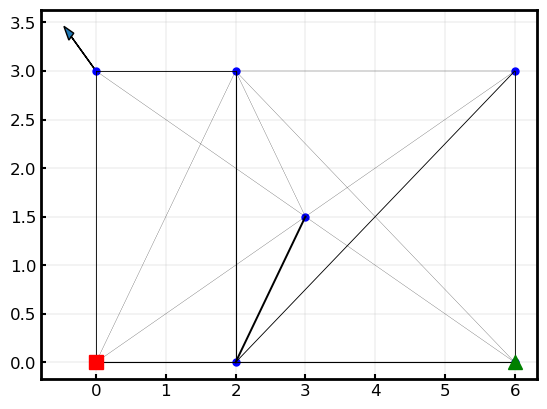

12.323061959511682
(27.948119185106606, {'member_1': 2.082686354702264, 'member_2': 3.879468253908074, 'member_3': 2.347409713390327, 'member_4': 1.5319156189009775, 'member_5': 2.775422357623899, 'member_6': 4.174507425924541, 'member_7': 2.396493413007547, 'member_8': 0.8865190010072247, 'member_9': 0.660364656483531, 'member_10': 0.9516998054914209, 'member_11': 3.239302907420716, 'member_12': 0.6717895101806317, 'member_13': 0.6387777625624469, 'member_14': 0.6633560209476771, 'member_15': 0.3246636095891853, 'member_16': 0.7237427739661414})


In [ ]:
t = make_truss(node_dict, member_dict, load, supports)
plot_truss(t)
print(np.max(np.abs(np.array(list(t.member_stress().values())))))
print(to.structure_mass())

In [ ]:
def node_dict_to_vector(node_dict):
    """Flattens a node dict to a 1D list in consistent order."""
    sorted_keys = sorted(node_dict.keys())
    vec = []
    for key in sorted_keys:
        vec.extend(node_dict[key])
    return vec, sorted_keys  # return order for decoding later

def vector_to_node_dict(vec, keys):
    """Reconstructs a node dict from a 1D vector and key order."""
    assert len(vec) == 2 * len(keys), "Mismatch between vector length and number of nodes"
    node_dict = {}
    for i, key in enumerate(keys):
        node_dict[key] = [vec[2*i], vec[2*i + 1]]
    return node_dict


dummy_node,ss = node_dict_to_vector(node_dict)
new_dict = vector_to_node_dict(dummy_node, ss)

In [ ]:
def objective_func(x,ss, member_dict, load, supports):
    new_dict = vector_to_node_dict(x, ss)
    t = make_truss(new_dict, member_dict, load, supports)
    max_stress = max(np.abs(np.array(list(t.member_stress().values()))))
    w,_ = t.structure_mass()
    return max_stress,w

def contraint_func_w(x,ss, member_dict, load, supports, max_weight=30):
    new_dict = vector_to_node_dict(x, ss)
    t = make_truss(new_dict, member_dict, load, supports)
    # max_stress = max(np.abs(np.array(list(t.member_stress().values()))))
    curr_weight,_ = t.structure_mass()
    return max_weight-curr_weight

def contraint_func_s(x,ss, member_dict, load, supports, max_stress=10):
    new_dict = vector_to_node_dict(x, ss)
    t = make_truss(new_dict, member_dict, load, supports)
    curr_stress = max(np.abs(np.array(list(t.member_stress().values()))))
    return max_stress-curr_stress
    
constraints = [
    {'type': 'ineq', 'fun': contraint_func_w},
    {'type': 'ineq', 'fun': contraint_func_s},
]
bounds = [(0, 10)] * (2 * len(node_dict))


In [ ]:
objective_func(dummy_node,ss, member_dict, load, supports)
# contraint_func_s(dummy_node,ss, member_dict, load, supports)


(np.float64(12.323061959511682), 27.76290562851855)

In [ ]:
from scipy.optimize import minimize
from functools import partial

# Wrap the objective
obj_fn = partial(objective_func, ss=ss, member_dict=member_dict, load=load, supports=supports)

# Wrap constraints
con_w = {'type': 'ineq', 'fun': partial(contraint_func_w, ss=ss, member_dict=member_dict, load=load, supports=supports)}
con_s = {'type': 'ineq', 'fun': partial(contraint_func_s, ss=ss, member_dict=member_dict, load=load, supports=supports)}

constraints = [con_w, con_s]
x0, ss = node_dict_to_vector(node_dict)  # ss: sorted key list
# bounds = [(0, 10)] * len(x0)


fixed_nodes = set(load.keys()) | set(supports.keys())

def make_position_bounds(node_dict, sorted_keys, fixed_nodes, lower=0.0, upper=10.0):
    bounds = []
    for key in sorted_keys:
        x, y = node_dict[key]
        if key in fixed_nodes:
            bounds.extend([(x, x), (y, y)])  # fixed
        else:
            bounds.extend([(lower, upper), (lower, upper)])  # free
    return bounds


bounds = make_position_bounds(node_dict, ss, fixed_nodes)
# print(bounds)

def make_deviation_bounds(node_dict, sorted_keys, max_deviation=0.5):
    bounds = []
    for key in sorted_keys:
        x0, y0 = node_dict[key]
        bounds.extend([
            (x0 - max_deviation, x0 + max_deviation),  # x bound
            (y0 - max_deviation, y0 + max_deviation)   # y bound
        ])
    return bounds

bounds = make_deviation_bounds(node_dict, ss)

In [ ]:
result = minimize(
    fun=obj_fn,
    x0=x0,
    bounds=bounds,
    method='Nelder-Mead',
    options={
        'disp': True,     # <-- enables internal convergence logging
        'xatol': 1e-4,    # absolute tolerance for x
        'fatol': 1e-4,    # absolute tolerance for function value
        'return_all': True,  # optional: returns full simplex history
        'maxiter': 100
    }
)


/tmp/ipykernel_1189351/3914230826.py:1: RuntimeWarning: Maximum number of iterations has been exceeded.
  result = minimize(


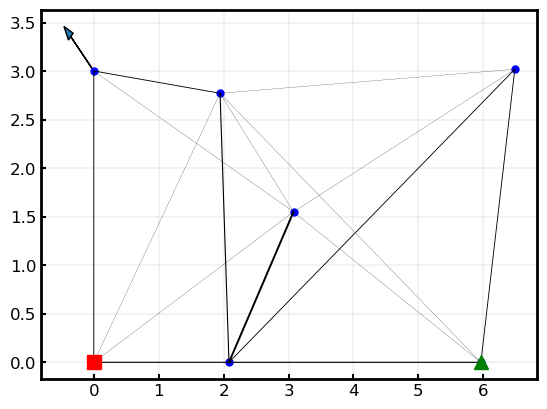

10.395925117812055
(27.948119185106606, {'member_1': 2.082686354702264, 'member_2': 3.879468253908074, 'member_3': 2.347409713390327, 'member_4': 1.5319156189009775, 'member_5': 2.775422357623899, 'member_6': 4.174507425924541, 'member_7': 2.396493413007547, 'member_8': 0.8865190010072247, 'member_9': 0.660364656483531, 'member_10': 0.9516998054914209, 'member_11': 3.239302907420716, 'member_12': 0.6717895101806317, 'member_13': 0.6387777625624469, 'member_14': 0.6633560209476771, 'member_15': 0.3246636095891853, 'member_16': 0.7237427739661414})


In [ ]:
new_dict = vector_to_node_dict(result.x, ss)
to = make_truss(new_dict, member_dict, load, supports)
plot_truss(to)
print(np.max(np.abs(np.array(list(to.member_stress().values())))))
print(to.structure_mass())

In [ ]:
new_dict

{'node_1': [np.float64(0.00011309517539787967),
  np.float64(-7.316551086895758e-09)],
 'node_2': [np.float64(5.98560332884024), np.float64(0.0001231365850285377)],
 'node_3': [np.float64(1.9161435035076737),
  np.float64(0.00010418944387789668)],
 'node_4': [np.float64(-0.00012881402816498452),
  np.float64(3.0341982114860695)],
 'node_5': [np.float64(1.94471095020267), np.float64(2.847983393917942)],
 'node_6': [np.float64(6.417249733198984), np.float64(3.0841314304890286)],
 'node_7': [np.float64(3.0999770516247454), np.float64(1.5192993370866397)]}

In [ ]:
np.max(np.abs(np.array(list(to.member_stress().values()))))

np.float64(10.66677576871055)

In [ ]:
import numpy as np
from pymoo.core.problem import Problem

In [ ]:
from pymoo.core.problem import Problem
import numpy as np

class TrussOptimizationProblem(Problem):
    def __init__(self, ss, member_dict, load, supports):
        super().__init__(n_var=len(ss) * 2,  # x and y for each node
                         n_obj=2,           # stress and weight
                         n_constr=0,        # no inequality constraints for now
                         xl=0.0,            # lower bound for each variable
                         xu=10.0)           # upper bound for each variable

        self.ss = ss
        self.member_dict = member_dict
        self.load = load
        self.supports = supports

    def _evaluate(self, x, out, *args, **kwargs):
        F = []
        for i, xi in enumerate(x):
            try:
                stress, weight = objective_func(xi, self.ss, self.member_dict, self.load, self.supports)
            except Exception as e:
                print(f"Sample {i} failed: {e}")
                stress, weight = 1e6, 1e6
            F.append([stress, weight])
        out["F"] = np.array(F)



In [ ]:
from pymoo.algorithms.moo.nsga2 import NSGA2, NSGA2
from pymoo.optimize import minimize
from pymoo.visualization.scatter import Scatter
from joblib import Parallel, delayed
from pymoo.termination import get_termination
from pymoo.core.evaluator import Evaluator

# Create the problem
problem = TrussOptimizationProblem(ss, member_dict, load, supports)

# Run optimizer
# result = minimize(
#     problem,
#     algorithm=NSGA2(pop_size=50),
#     termination=("n_gen", 100),
#     seed=1,
#     verbose=True
# )


res = minimize(
    problem,
    algorithm=NSGA2(pop_size=50),
    termination=("n_gen", 100),
    seed=1,
    verbose=True,
    n_jobs=8  # ✅ This is all you need for most cases
)

n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |       50 |      5 |             - |             -
     2 |      100 |      7 |  0.0926664024 |             f
     3 |      150 |      3 |  0.2765320149 |         ideal
     4 |      200 |      4 |  0.0343756226 |             f
     5 |      250 |      5 |  0.0086622334 |         ideal
     6 |      300 |      7 |  0.0574969647 |             f
     7 |      350 |      5 |  0.1748126713 |         ideal
     8 |      400 |      8 |  0.1114282594 |         ideal
     9 |      450 |     11 |  0.0367404242 |             f
    10 |      500 |     11 |  0.0179590115 |         nadir
    11 |      550 |      9 |  0.1487574794 |         ideal
    12 |      600 |      5 |  0.0180151319 |         ideal
    13 |      650 |      7 |  0.0192310252 |         ideal
    14 |      700 |      6 |  0.0467864157 |         ideal
    15 |      750 |      8 |  0.0328297058 |             f
    16 |      800 |      9 |  0.0208125925 |         ide

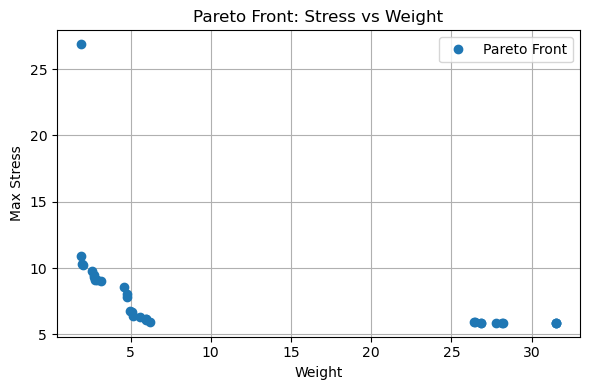

In [ ]:
pareto_objectives = res.F  # shape: (n_points, 2)
# Extract stress and weight
import matplotlib.pyplot as plt

stress = pareto_objectives[:, 0]
weight = pareto_objectives[:, 1]

plt.figure(figsize=(6, 4))
plt.plot(weight, stress, 'o', label="Pareto Front")
plt.xlabel("Weight")
plt.ylabel("Max Stress")
plt.title("Pareto Front: Stress vs Weight")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
